In [61]:
import numpy as np

class PDWorld_env:
    def __init__(self, alpha = 0.3):
        self.grid_size = 5
        self.num_agents = 3
        self.num_pickups = 3
        self.num_dropoffs = 3
        self.state_size = self.grid_size ** 2
        self.action_size = 6 # Up, Down, Left, Right, Pickup, Dropoff
        self.q_tables = [{} for _ in range(self.num_agents)]  # Q-table for each agent
        self.alpha = alpha  
        self.gamma = 0.5  
        self.epsilon = 0.1 

    def get_state(self):
        # Return the current state of the environment
        return self.agents, self.pickups, self.dropoffs

    def reset(self):
        self.agents = [(2, 0), (2, 2), (2, 4)]  # Initial positions of agents
        self.pickups = [(4, 0), (3, 1), (1, 4)]  # Pickup spots
        self.dropoffs = [(0, 0), (0, 2), (4, 3)]  # Dropoff spots
        self.passenger_picked = [False] * self.num_agents
        self.carries_block = [False] * self.num_agents 
        self.blocks_on_ground = {(x, y): 4 if (x, y) in self.pickups else 0 for x in range(self.grid_size) for y in range(self.grid_size)}
        
        return self.get_state() 
    


    # Perform actions and calculate rewards
    def step(self, actions):

        reward = 0
        state = (tuple(self.agents), tuple(self.pickups), tuple(self.dropoffs))

                
        for i, action in enumerate(actions):
            x, y = self.agents[i]  # Extract x and y coordinates

            if action == 0 and all((x, y - 1) != agent for agent in self.agents):  # Up
                if y > 0:
                    self.agents[i] = (x, y - 1)
                    reward =  -1

            elif action == 1 and all((x, y + 1) != agent for agent in self.agents):  # Down
                if y < self.grid_size - 1:
                    self.agents[i] = (x, y + 1)
                    reward =  -1

            elif action == 2 and all((x - 1, y) != agent for agent in self.agents):  # Left
                if x > 0:
                    self.agents[i] = (x - 1, y)
                    reward =  -1

            elif action == 3 and all((x + 1, y) != agent for agent in self.agents):  # Right
                if x < self.grid_size - 1:
                    self.agents[i] = (x + 1, y)
                    reward =  -1

            elif action == 4:  # Pick up
                # Pick up passenger if at pick-up spot, passenger not already picked up, and there is at least one block
                if (x, y) in self.pickups and not self.passenger_picked[i] and (x, y) in self.blocks_on_ground and not self.carries_block[i]:
                    self.passenger_picked[i] = True
                    reward = 13  # Add reward for picking up passenger

                    self.blocks_on_ground.pop((x, y), None)  # Remove block from the pickup cell
                    self.carries_block[i] = True

            elif action == 5:  # Drop off
                # Drop off passenger if at drop-off spot, passenger picked up, agent carries a block, and dropoff cell has less than 4 blocks
                if (x, y) in self.dropoffs and self.passenger_picked[i] and self.carries_block[i] and self.blocks_on_ground.get((x, y), 0) < 4:
                    self.passenger_picked[i] = False
                    reward = 13

                    self.blocks_on_ground[(x, y)] = self.blocks_on_ground.get((x, y), 0) + 1  # Place block on the dropoff cell
                    self.carries_block[i] = False  # Update agent's state to not carrying a block


        # Call update_q_table after all actions have been taken
        for i, action in enumerate(actions):
            self.update_q_table(i, state, action, reward, (tuple(self.agents), tuple(self.pickups), tuple(self.dropoffs)))

        # Return Agent locations and step reward
        return self.agents, reward
    
    
    
    def update_q_table(self, agent_id, state, action, reward, next_state):
            # Get Q-values for the current state
            q_values = self.q_tables[agent_id].setdefault(state, np.zeros(self.action_size))
            # print(q_values)
            # Get the maximum Q-value for the next state
            next_q_values = self.q_tables[agent_id].setdefault(next_state, np.zeros(self.action_size))
            max_next_q_value = np.max(next_q_values)
            # Update Q-value for the taken action
            q_values[action] += self.alpha * (reward + self.gamma * max_next_q_value - q_values[action])

            
    def is_done(self):
        #All dropoff spots have 4 blocks
        all_dropoffs_full = all(self.blocks_on_ground.get(dropoff) == 4 for dropoff in self.dropoffs)
        
        # All agents are not carrying any blocks
        all_agents_not_carrying = all(not carrying_block for carrying_block in self.carries_block)


        episode_done =  all_dropoffs_full and all_agents_not_carrying

        return episode_done


In [118]:
import matplotlib.pyplot as plt

# Function to visualize Environment
# Dropoff spots = yellow; pickup spots = green; agents = blue
def visualize_world(agents, pickups, dropoffs, grid_size):
    grid = np.zeros((grid_size, grid_size))
    
    for agent in agents:
        grid[agent] = 1
    
    for pickup in pickups:
        grid[pickup] = 2
    
    for dropoff in dropoffs:
        grid[dropoff] = 3
    
    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.show()

In [49]:
# Experiment 1 (first 500 steps)
# Create an instance of PDWorld_env
env = PDWorld_env(alpha = 0.3)

# Reset the environment to initialize the state
state = env.reset()
total_reward = 0

# Set a fixed seed for reproducibility
np.random.seed(42)

# Run PRandom for the first 500 steps
for step in range(500):
    # Randomly select actions for each agent

    actions = np.random.randint(0, env.action_size, size=env.num_agents)
    
    # Perform actions and calculate rewards
    state, reward = env.step(actions)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    # print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed. Reward = ", total_reward)


[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[-0.3  0.   0.   0.   0.   0. ]
[-0.3  0.   0.   0.   0.   0. ]
[ 0.   0.  -0.3  0.   0.   0. ]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 

In [45]:
# Experiment 1A (Run first 500 steps)
# Continue PRandom policy



for step in range(8500):
    # Randomly select actions for each agent
    actions = np.random.randint(0, env.action_size, size=env.num_agents)
    
    # Perform actions and calculate rewards
    state, reward = env.step(actions)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed. Reward = ", total_reward)


Steps completed. Reward =  -7713


In [43]:
print(env.q_tables)

[{(((2, 0), (2, 2), (2, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([ 0. ,  0. ,  0. , -0.3,  0. ,  0. ]), (((3, 0), (2, 2), (1, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([ 0. ,  0. , -0.3,  0. ,  0. ,  0. ]), (((2, 0), (1, 2), (0, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([ 0. ,  0. ,  0. ,  0. , -0.3,  0. ]), (((2, 0), (2, 2), (0, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([ 0. ,  0. ,  0. , -0.3,  0. ,  0. ]), (((3, 0), (2, 2), (0, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([ 0. , -0.3,  0. ,  0. ,  0. ,  0. ]), (((3, 1), (3, 2), (0, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([-0.3,  0. ,  0. ,  0. ,  0. ,  0. ]), (((3, 0), (4, 2), (0, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([ 0. ,  0. ,  0. ,  0. ,  0. , -0.3]), (((3, 0), (4, 2), (1, 4)), ((4, 0), (3, 1), (1, 4)), ((0, 0), (0, 2), (4, 3))): array([-0.3,  0. ,  0. ,  0. ,  0. , -0.3])

In [6]:
# Experiment 1B (Run first 500 steps)
# PGreedy policy

for step in range(8500):
    actions = []

    for i, agent in enumerate(env.agents):
            x, y = agent  # Extract x and y coordinates
            

            # PGREEDY policy
            if (x, y) in env.pickups and not env.passenger_picked[i] and (x, y) in env.blocks_on_ground and not env.carries_block[i]:
                action = 4  

            if (x, y) in env.dropoffs and env.passenger_picked[i] and env.carries_block[i] and env.blocks_on_ground.get((x, y), 0) < 4:
                action = 5

            else:
                key = str(state)  # Convert the state into a hashable form
                q_values = env.q_tables[i].setdefault(key, np.zeros(env.action_size))
                best_actions = np.where(q_values == np.max(q_values))[0]
                # Break the tie
                action = np.random.choice(best_actions)

                actions.append(action)

    # Perform actions and calculate rewards
    state, reward = env.step(actions)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)
    
    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed. Reward = ", total_reward)

Steps completed. Reward =  -14987


In [7]:
# Experiment 1C (Run first 500 steps)
# PExploit policy


for step in range(8500):
    actions = []

    for i, agent in enumerate(env.agents):
            x, y = agent  # Extract x and y coordinates
            

            # PEXPLOIT policy
            if (x, y) in env.pickups and not env.passenger_picked[i] and (x, y) in env.blocks_on_ground and not env.carries_block[i]:
                action = 4  

            if (x, y) in env.dropoffs and env.passenger_picked[i] and env.carries_block[i] and env.blocks_on_ground.get((x, y), 0) < 4:
                action = 5

            
            else:
                key = str(state)  # Convert the state into a hashable form
                q_values = env.q_tables[i].setdefault(key, np.zeros(env.action_size))
                best_actions = np.where(q_values == np.max(q_values))[0]
                
                if np.random.rand() < 0.2:
                    # Choose a different applicable operator randomly
                    available_actions = [a for a in range(env.action_size) if a not in [4, 5] or (a == 4 and (x, y) in env.pickups) or (a == 5 and (x, y) in env.dropoffs)]
                    action = np.random.choice(available_actions)
                else:
                    # Exploit: Choose the action with the highest Q-value
                    action = np.random.choice(best_actions)
                actions.append(action)
                
    # Perform actions and calculate rewards
    state, reward = env.step(actions)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)
    
    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed. Reward = ", total_reward)

Steps completed. Reward =  -22594


#### Experiment 3 (Rerun experiment 1.C with alpha = 0.15)

In [33]:
# Run first 500 steps


# Initialize with alpha=0.15
env1 = PDWorld_env(alpha = 0.15)  

envTEST = PDWorld_env(alpha = 0.15)
stateTEST = envTEST.reset()
# Reset the environment to initialize the state
state = env1.reset()

total_reward = 0

# Set a fixed seed for reproducibility
np.random.seed(42)

# Run PRandom for the first 500 steps
for step in range(500):
    # Randomly select actions for each agent
    actions = np.random.randint(0, env1.action_size, size=env1.num_agents)
    
    # Perform actions and calculate rewards
    state, reward = env1.step(actions)
    total_reward += reward

    if env1.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed with alpha = 0.15. Reward = ", total_reward)



Steps completed with alpha = 0.15. Reward =  -376


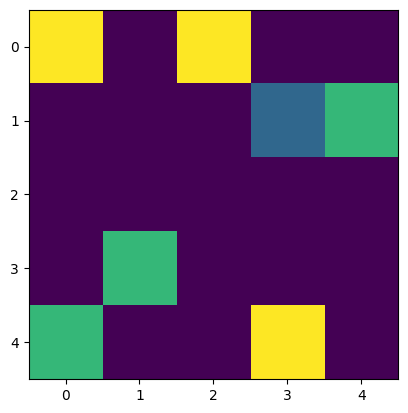

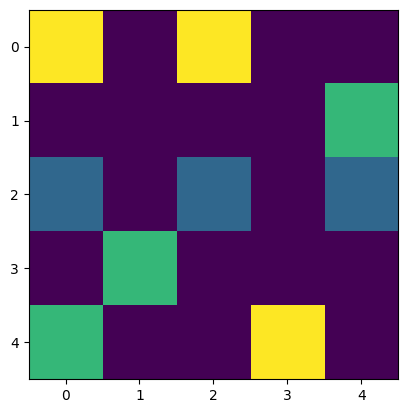

In [34]:
visualize_world(env1.agents, env1.pickups, env1.dropoffs, env1.grid_size)
visualize_world(envTEST.agents, envTEST.pickups, envTEST.dropoffs, envTEST.grid_size)

#### Experiment 3 Continued (Next 8500 steps with alpha = 0.15)

In [13]:
# PExploit policy
for step in range(8500):
    actions = []

    for i, agent in enumerate(env1.agents):
            x, y = agent  # Extract x and y coordinates
            

            # PEXPLOIT policy
            if (x, y) in env1.pickups and not env1.passenger_picked[i] and (x, y) in env1.blocks_on_ground and not env1.carries_block[i]:
                action = 4  

            if (x, y) in env1.dropoffs and env1.passenger_picked[i] and env1.carries_block[i] and env1.blocks_on_ground.get((x, y), 0) < 4:
                action = 5

            
            else:
                key = str(state)  # Convert the state into a hashable form
                q_values = env1.q_tables[i].setdefault(key, np.zeros(env1.action_size))
                best_actions = np.where(q_values == np.max(q_values))[0]
                
                if np.random.rand() < 0.2:
                    # Choose a different applicable operator randomly
                    available_actions = [a for a in range(env1.action_size) if a not in [4, 5] or (a == 4 and (x, y) in env1.pickups) or (a == 5 and (x, y) in env1.dropoffs)]
                    action = np.random.choice(available_actions)
                else:
                    # Exploit: Choose the action with the highest Q-value
                    action = np.random.choice(best_actions)
                actions.append(action)
                
    # Perform actions and calculate rewards
    state, reward = env1.step(actions)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)
    
    # Check if the episode is done
    if env1.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed with alpha = 0.15. Reward = ", total_reward)

Steps completed with alpha = 0.15. Reward =  -7979


#### Experiment 3 continued (First 500 steps with alpha = 0.45)

In [129]:

import matplotlib.pyplot as plt

class path_viz:
    def __init__(self, env):
        self.environ = env
        self.agent_starts = env.agents
        print(self.agent_starts)
        self.grid_viz = np.zeros((self.environ.grid_size, self.environ.grid_size))
        
    def update_viz(self, agent_id, actions):
        x, y = self.agent_starts[agent_id]
        for action in actions:
            # UDLRPD
            if(action == 1):
                if(y > 0):
                    self.grid_viz[x, y - 1] += 0.01
                    x, y = x, y - 1
            if(action == 2):
                if(y < self.environ.grid_size - 1):
                    self.grid_viz[x, y + 1] += 0.01
                    x, y = x, y + 1
            if(action == 3):
                if(x > 0):
                    self.grid_viz[x - 1, y] += 0.01
                    x, y = x - 1, y
            if(action == 4):
                if(x < self.environ.grid_size - 1):
                    self.grid_viz[x + 1, y] += 0.01
                    x, y = x + 1, y
    
    def show_viz(self):
        plt.imshow(self.grid_viz, cmap='RdBu', interpolation='nearest')
        
        print(self.agent_starts)
        # for agent in self.agent_starts:
        #     plt.text(agent[1], agent[0], "A", ha="center", va="center", color="w")
            
        for pickup in self.environ.pickups:
            plt.text(pickup[1], pickup[0], "P", ha="center", va="center", color="b")
            
        for dropoff in self.environ.dropoffs:
            plt.text(dropoff[1], dropoff[0], "D", ha="center", va="center", color="r")
            
        plt.show()

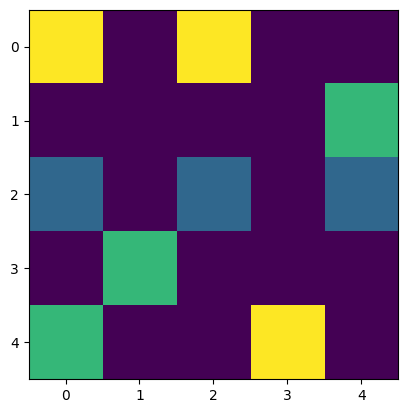

[(2, 0), (2, 2), (2, 4)]
Steps completed with alpha=0.45. Reward =  -376


In [130]:
# Initialize with alpha=0.45
env2 = PDWorld_env(alpha = 0.45)  



# Reset the environment to initialize the state
state = env2.reset()
total_reward = 0

#TESTING STUFF
visualize_world(env2.agents, env2.pickups, env2.dropoffs, env2.grid_size)
path_VIZ_TEST = path_viz(env2)


# Set a fixed seed for reproducibility
np.random.seed(42)

# Run PRandom for the first 500 steps
for step in range(500):
    # Randomly select actions for each agent
    actions = np.random.randint(0, env2.action_size, size=env2.num_agents)
    
    # Perform actions and calculate rewards
    state, reward = env2.step(actions)
    total_reward += reward

    if env2.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed with alpha=0.45. Reward = ", total_reward)

#### Experiment 3 continued (Next 8500 steps with alpha = 0.45)

aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh
aaahhhh


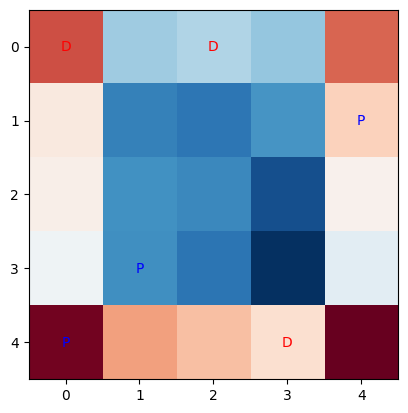

Steps completed with alpha = 0.45. Reward =  -15599


In [133]:
# PExploit policy



for step in range(8500):
    actions = []

    for i, agent in enumerate(env2.agents):
            x, y = agent  # Extract x and y coordinates
            

            # PEXPLOIT policy
            if (x, y) in env2.pickups and not env2.passenger_picked[i] and (x, y) in env2.blocks_on_ground and not env2.carries_block[i]:
                action = 4  

            if (x, y) in env2.dropoffs and env2.passenger_picked[i] and env2.carries_block[i] and env2.blocks_on_ground.get((x, y), 0) < 4:
                action = 5

            
            else:
                key = str(state)  # Convert the state into a hashable form
                q_values = env2.q_tables[i].setdefault(key, np.zeros(env2.action_size))
                best_actions = np.where(q_values == np.max(q_values))[0]
                
                if np.random.rand() < 0.2:
                    # Choose a different applicable operator randomly
                    available_actions = [a for a in range(env2.action_size) if a not in [4, 5] or (a == 4 and (x, y) in env2.pickups) or (a == 5 and (x, y) in env2.dropoffs)]
                    action = np.random.choice(available_actions)
                    # if(action >= 4):
                    #     print("aaahhhh")
                else:
                    # Exploit: Choose the action with the highest Q-value
                    action = np.random.choice(best_actions)
                actions.append(action)
                
    # Perform actions and calculate rewards
    state, reward = env2.step(actions)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    # print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)
    for i in range(2):
        path_VIZ_TEST.update_viz(i, actions)
    
    # Check if the episode is done
    if env2.is_done():
        print("Episode done at step", step + 1)
        break
    
     
path_VIZ_TEST.show_viz()
print("Steps completed with alpha = 0.45. Reward = ", total_reward)